# Post snap positions prediction using pre snap tracking data

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishabhpatil2002","key":"95949c4b1a56eb312b8bddac2d8af522"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [4]:
!kaggle competitions download -c nfl-big-data-bowl-2025

 99% 1.13G/1.14G [00:05<00:00, 252MB/s]
100% 1.14G/1.14G [00:05<00:00, 217MB/s]


In [5]:
!unzip nfl-big-data-bowl-2025.zip -d nfl_data

Archive:  nfl-big-data-bowl-2025.zip
  inflating: nfl_data/games.csv      
  inflating: nfl_data/player_play.csv  
  inflating: nfl_data/players.csv    
  inflating: nfl_data/plays.csv      
  inflating: nfl_data/tracking_week_1.csv  
  inflating: nfl_data/tracking_week_2.csv  
  inflating: nfl_data/tracking_week_3.csv  
  inflating: nfl_data/tracking_week_4.csv  
  inflating: nfl_data/tracking_week_5.csv  
  inflating: nfl_data/tracking_week_6.csv  
  inflating: nfl_data/tracking_week_7.csv  
  inflating: nfl_data/tracking_week_8.csv  
  inflating: nfl_data/tracking_week_9.csv  


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [7]:
file_paths = [f"/content/nfl_data/tracking_week_{i}.csv" for i in range(1, 6)]

data = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

In [8]:
data['time'] = data['time'].str.strip()

data['time'] = pd.to_datetime(data['time'], format="%Y-%m-%d %H:%M:%S.%f", errors='coerce')

data['time'] = data['time'].dt.floor('S')

<ipython-input-8-ef97145dd699>:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data['time'] = data['time'].dt.floor('S')


In [9]:
data

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022091200,64,35459.0,Kareem Jackson,1,BEFORE_SNAP,2022-09-13 00:16:03,22.0,DEN,right,51.06,28.550000,0.72,0.37,0.07,246.17,68.34,huddle_break_offense
1,2022091200,64,35459.0,Kareem Jackson,2,BEFORE_SNAP,2022-09-13 00:16:03,22.0,DEN,right,51.13,28.570000,0.71,0.36,0.07,245.41,71.21,NaN
2,2022091200,64,35459.0,Kareem Jackson,3,BEFORE_SNAP,2022-09-13 00:16:03,22.0,DEN,right,51.20,28.590000,0.69,0.23,0.07,244.45,69.90,NaN
3,2022091200,64,35459.0,Kareem Jackson,4,BEFORE_SNAP,2022-09-13 00:16:03,22.0,DEN,right,51.26,28.620000,0.67,0.22,0.07,244.45,67.98,NaN
4,2022091200,64,35459.0,Kareem Jackson,5,BEFORE_SNAP,2022-09-13 00:16:03,22.0,DEN,right,51.32,28.650000,0.65,0.34,0.07,245.74,62.83,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34788852,2022100600,4724,NaN,football,162,AFTER_SNAP,2022-10-07 03:44:50,NaN,football,left,11.88,39.959999,7.21,2.40,0.73,NaN,NaN,pass_outcome_incomplete
34788853,2022100600,4724,NaN,football,163,AFTER_SNAP,2022-10-07 03:44:50,NaN,football,left,12.31,40.529999,7.02,2.36,0.72,NaN,NaN,NaN
34788854,2022100600,4724,NaN,football,164,AFTER_SNAP,2022-10-07 03:44:50,NaN,football,left,12.74,41.080002,6.80,2.44,0.69,NaN,NaN,NaN
34788855,2022100600,4724,NaN,football,165,AFTER_SNAP,2022-10-07 03:44:50,NaN,football,left,13.16,41.599998,6.60,2.40,0.67,NaN,NaN,NaN


In [10]:
data = data.sort_values(by=['gameId', 'playId', 'nflId', 'time'])
data['nflId'] = data['nflId'].fillna(0)
data['o'] = data['o'].fillna(0)
data.loc[data['frameType'] == 'SNAP', 'frameType'] = 'BEFORE_SNAP'

data_grouped = data.groupby(['gameId', 'playId', 'time', 'nflId']).agg(
    x=('x', 'mean'),
    y=('y', 'mean'),
    s=('s', 'mean'),
    a=('a', 'mean'),
    o=('o', 'mean'),
    frameType=('frameType', 'first')
).reset_index()

In [11]:
min_x = data_grouped['x'].min()
max_x = data_grouped['x'].max()
min_y = data_grouped['y'].min()
max_y = data_grouped['y'].max()

In [12]:
scaler = MinMaxScaler()
input_features = ['x', 'y', 's', 'a', 'o']
data_grouped[input_features] = scaler.fit_transform(data_grouped[input_features])

In [13]:
data_grouped[input_features].shape

(3651802, 5)

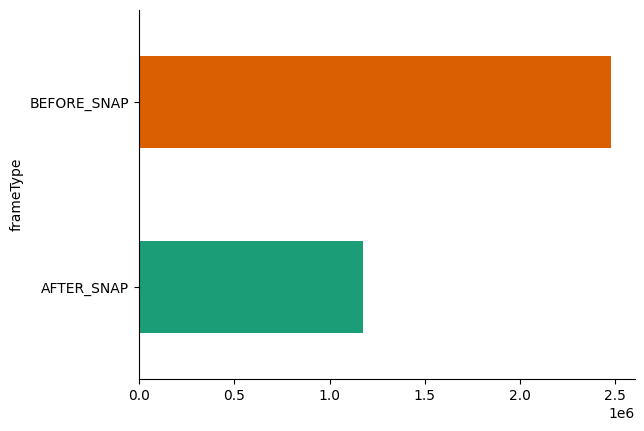

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
data_grouped.groupby('frameType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
data_grouped_by_play = data_grouped.groupby(['gameId', 'playId', 'frameType']).agg(
    time=('time', 'max')
).reset_index()
data_grouped_by_play.drop(data_grouped_by_play[data_grouped_by_play['frameType'] == 'AFTER_SNAP'].index, inplace=True)
time_dict = data_grouped_by_play.set_index(['gameId','playId'])['time'].to_dict()

In [16]:
from datetime import datetime, timedelta

results = []

triplets = data_grouped[['gameId', 'playId', 'time']].drop_duplicates()

play_dict = {};

for _, row in triplets.iterrows():
    game_id, play_id, time = row['gameId'], row['playId'], row['time']


    startTime = time_dict.get((game_id, play_id)) - timedelta(seconds=9);
    endTime = time_dict.get((game_id, play_id)) + timedelta(seconds=5);

    if time >= startTime and time <= endTime:

        filtered_df = data_grouped[
            (data_grouped['gameId'] == game_id) &
            (data_grouped['playId'] == play_id) &
            (data_grouped['time'] == time)
        ]

        sorted_filtered_df = filtered_df.sort_values(by='nflId', ascending=True)

        array = sorted_filtered_df[['x', 'y', 's', 'a', 'o']].to_numpy()

        key = (game_id, play_id)

        if key not in play_dict:
            play_dict[key] = []
        play_dict[key].append(array)


In [17]:
np.array(play_dict[(2022090800, 56)]).shape

(15, 23, 5)

In [18]:
def is_homogeneous(lst):
    """Check if all elements in a list have the same shape or structure."""
    if not lst:
        return True
    first_shape = np.array(lst[0]).shape
    return all(np.array(el).shape == first_shape for el in lst)

In [19]:
temp = []
for key in play_dict:
    data = play_dict[key]
    if isinstance(data, list) and is_homogeneous(data):
        curr = np.array(data)
        if curr.shape == (15, 23, 5):
            temp.append(curr)

data = np.array(temp)

In [20]:
data.shape

(4784, 15, 23, 5)

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
from sklearn.model_selection import train_test_split


input_frames = 10
output_frames = 5

X = []
y = []

for i in range(data.shape[0]):
    for j in range(data.shape[1] - input_frames - output_frames + 1):
        X.append(data[i, j:j+input_frames, :, :])
        y.append(data[i, j+input_frames:j+input_frames+output_frames, :, :2])

X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], input_frames, 23 * 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(128, activation='relu', input_shape=(input_frames, 23 * 5), return_sequences=False),
    Dense(128, activation='relu'),
    RepeatVector(output_frames),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(23 * 2)),
])

model.add(tf.keras.layers.Reshape((output_frames, 23, 2)))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Epoch 1/20
96/96 [==============================] - 4s 21ms/step - loss: 0.0342 - mae: 0.1258 - val_loss: 0.0079 - val_mae: 0.0658
Epoch 2/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0075 - mae: 0.0640 - val_loss: 0.0076 - val_mae: 0.0640
Epoch 3/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0073 - mae: 0.0624 - val_loss: 0.0073 - val_mae: 0.0624
Epoch 4/20
96/96 [==============================] - 2s 16ms/step - loss: 0.0072 - mae: 0.0620 - val_loss: 0.0077 - val_mae: 0.0643
Epoch 5/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0072 - mae: 0.0617 - val_loss: 0.0071 - val_mae: 0.0613
Epoch 6/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0070 - mae: 0.0611 - val_loss: 0.0071 - val_mae: 0.0608
Epoch 7/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0070 - mae: 0.0608 - val_loss: 0.0071 - val_mae: 0.0615
Epoch 8/20
96/96 [==============================] - 2s 17ms/step - loss: 0.0069 - m